In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.regularizers import l2

import keras_tuner as kt
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import KFold

# Zadatak 1

In [55]:
print(f'S = {(2021+171+2021+175) % 10}')

S = 8


Koristi se skup podataka Star.csv. U datasetu se nalaze zabeleženi atributi iz astronomije (o zvezdama) o kojima će biti reči kasnije.

## Analiza skupa podataka

In [56]:
data = pd.read_csv('Star.csv')
data.head()

,Mean IP,Std IP,Excess krutosis IP,Skewness IP,Mean DM-SNR,Std DM-SNR,Excess kurtosis DM-SNR,Skewness DM-SNR,Class,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,126.835938,51.715384,-0.148753,-0.282879,4.728261,26.269071,6.965948,51.384494,0,NaN,NaN,NaN
1,95.679688,42.006126,0.311358,0.391927,1.545151,16.435507,12.030061,151.314193,0,NaN,NaN,NaN
2,107.367188,50.910441,0.094514,-0.530465,2.570234,16.843841,9.456757,107.196914,0,NaN,NaN,NaN
3,121.835938,57.059149,0.080463,-0.737542,1.340301,14.655249,12.928485,181.947107,0,NaN,NaN,NaN
4,108.421875,49.875252,0.356194,0.140122,11.224916,43.600214,3.942828,14.564314,0,NaN,NaN,NaN


In [57]:
data.shape

(5852, 12)

Odmah možemo uočiti da dataset u sebi sadrži tri nevalidne kolone koje će biti uklonjene. Ukupno je dato devet validnih kolona, tj. dato je osam atributa i jedna ciljna (target) promenljiva koja govori kojoj klasi pripada odbirak.
$$~$$

Skraćenica IP se odnosi na *Integrated Profile*. Ovo predstavlja prosečan signal (elektromagnetno zračenje) koji je zabeležen tokom više rotacija zvezde. Ovde su date: srednja vrednost signala, standardna devijacija, kurtosis i skewness.

Skraćenica DM-SNR se odnosi na Dispertion Measure - Signal to Noise Ratio. DM-SNR prikazuje odnos signal-šum za različite vrednosti disperzionih mera, što predstavlja meru usporenosti signal pri prosalsku kroz međuzvezdanu materiju. Ovde su takođe date: srednja vrednost, standardna devijacija, kurtosis i skewness.
$$~$$

Vidimo da su vrednosti koje uzimaju naši atributi na različitim skalama, tako da će biti potrebno normalizovati vrednosti pre nego što se proslede kao ulazi neuralnoj mreži.
$$~$$

Kako target promenljiva (Class) može da uzima samo vrednosti 0 i 1 zaključujemo da se radi o problemu binarne klasifikacije (najverovatnije da li dati odbirak pripada ili ne pripada nekoj vrsti zvezda).
$$~$$

Na raspolaganju ukupno imamo 5852 uzoraka koji će biti podeljeni u trening, validacioni i test skup.

In [58]:
data = data.iloc[:,:-3]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5852 entries, 0 to 5851
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Mean IP                 5852 non-null   float64
 1   Std IP                  5852 non-null   float64
 2   Excess krutosis IP      5852 non-null   float64
 3   Skewness IP             5852 non-null   float64
 4   Mean DM-SNR             5852 non-null   float64
 5   Std DM-SNR              5852 non-null   float64
 6   Excess kurtosis DM-SNR  5852 non-null   float64
 7   Skewness DM-SNR         5852 non-null   float64
 8   Class                   5852 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 411.6 KB


Među odbircima nema odbiraka sa nevalidnim vrednostima. Svi atributi su tipa float64, dok je target tipa int64 (međutim na osnovu ranije analize znamo da se može opisati i boolean tipom podatka).

In [59]:
data.describe()

,Mean IP,Std IP,Excess krutosis IP,Skewness IP,Mean DM-SNR,Std DM-SNR,Excess kurtosis DM-SNR,Skewness DM-SNR,Class
count,5852.000000,5852.000000,5852.000000,5852.000000,5852.000000,5852.000000,5852.000000,5852.000000,5852.000000
mean,99.774830,44.951215,1.029293,4.626404,20.642854,32.658238,7.197508,88.531784,0.280075
std,34.572214,7.773456,1.667142,10.098434,37.066301,23.210009,4.888534,105.450638,0.449074
min,5.812500,24.772042,-1.738021,-1.469010,0.213211,7.370432,-2.812353,-1.976976,0.000000
25%,84.126953,39.589112,0.078438,-0.114685,2.091973,15.110666,3.056539,8.550200,0.000000
50%,109.367188,45.723483,0.325254,0.428790,3.477843,21.505654,7.438698,62.505793,0.000000
75%,124.003906,50.239726,1.001698,2.604995,16.852007,48.582001,10.147022,124.489810,1.000000
max,185.257812,85.308572,8.069522,68.101622,217.371238,110.642211,34.539844,1191.000837,1.000000


Na osnovu datih statističkih opisa naših promenljivih možemo zaključiti da nema nevalidnih vrednosti (vrednosti koje ne bi imale smisla za neki atribut, a koje su posledica pogrešnog upisa ili nekog drugog previda).

In [60]:
X = np.array(data.iloc[:,:-1])
Y = np.array(data['Class'])

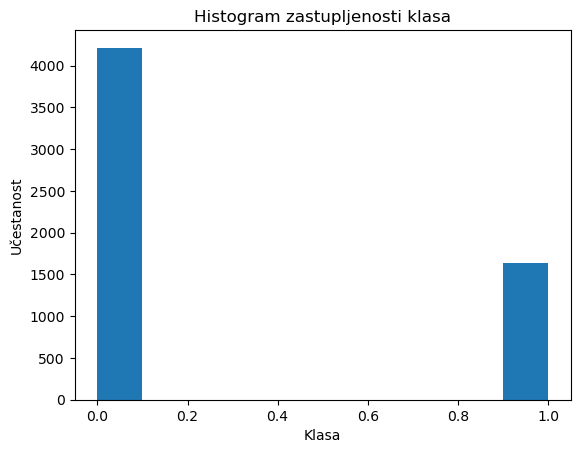

In [61]:
plt.figure()
plt.hist(Y)
plt.xlabel('Klasa')
plt.ylabel('Učestanost')
plt.title('Histogram zastupljenosti klasa')
plt.show()

Na datom histogramu zapažamo da postoji izražena nebalansiranost klasa. Ovo je problem koji može dovesti do toga da se model više fokusira na dobru klasifikaciju odbiraka klase 0. Neka od mogućih rešenja ovog problema su:
- Ponderisana loss funkcija (dodeljuje težine klasama - klasa 1 će imati veću težinu)
- Resampling
- Da obezbedimo da u batch-evima tokom treninga budu jednako balansirane obe klase

Ovde će se koristiti prva metoda, a ukoliko rezultati budu nezadovoljvajući može se pridodati i još neka od navedenih metoda.

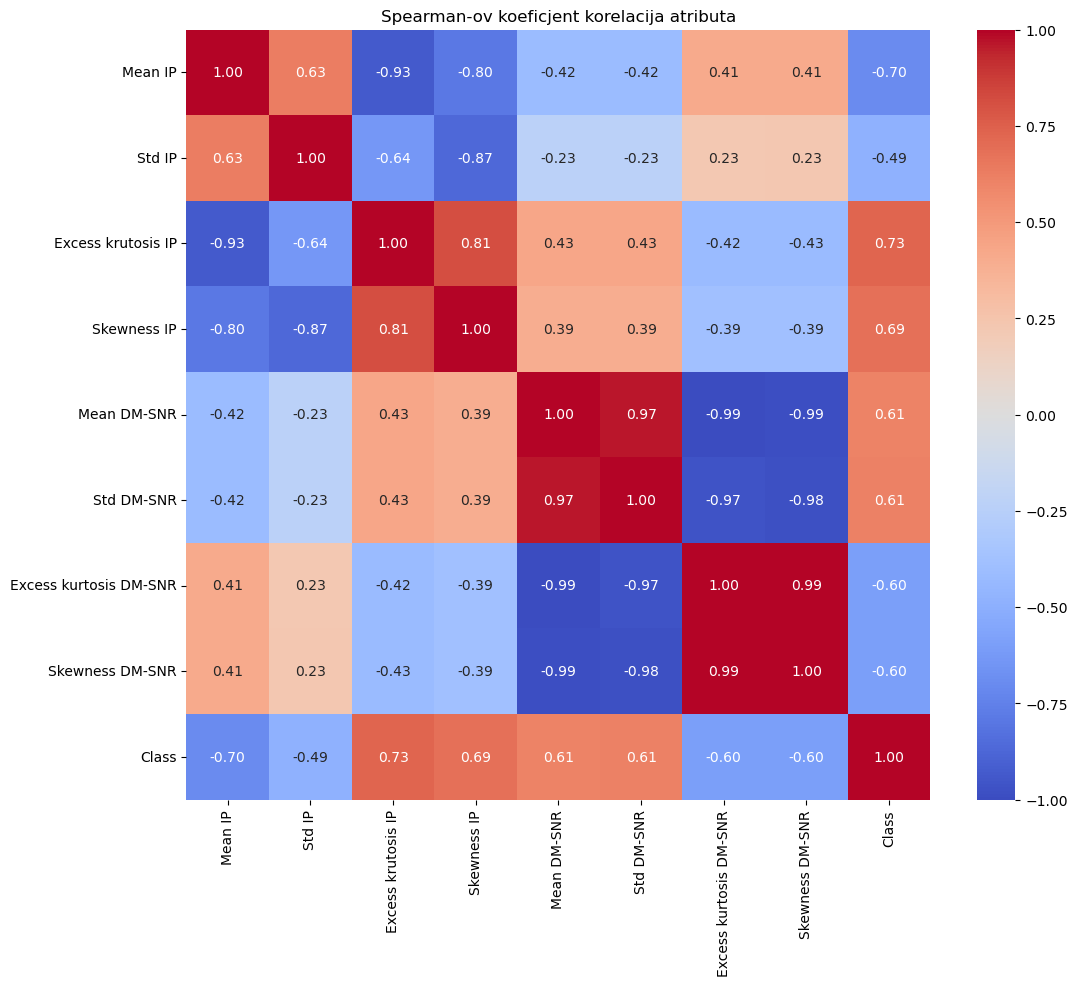

In [62]:
spearman_corr = data.corr(method="spearman")
plt.figure(figsize=(12, 10))
sns.heatmap(spearman_corr, cmap="coolwarm", vmin=-1, vmax=1, annot=True, fmt=".2f")
plt.title("Spearman-ov koeficjent korelacija atributa")
plt.show()

Vidimo da obeležja koja govore o DM-SNR imaju veoma jaku korelaciju (po apsolutnoj vrednosti veća od 0.95) tako da možemo da razmislimo o uklanjanju nekih od atributa radi dobijanja uprošćenijeg modela. Od ta četiri atributa ostavićemo samo Mean DM-SNR. Tako smo model sveli na 5 ulazna atributa.

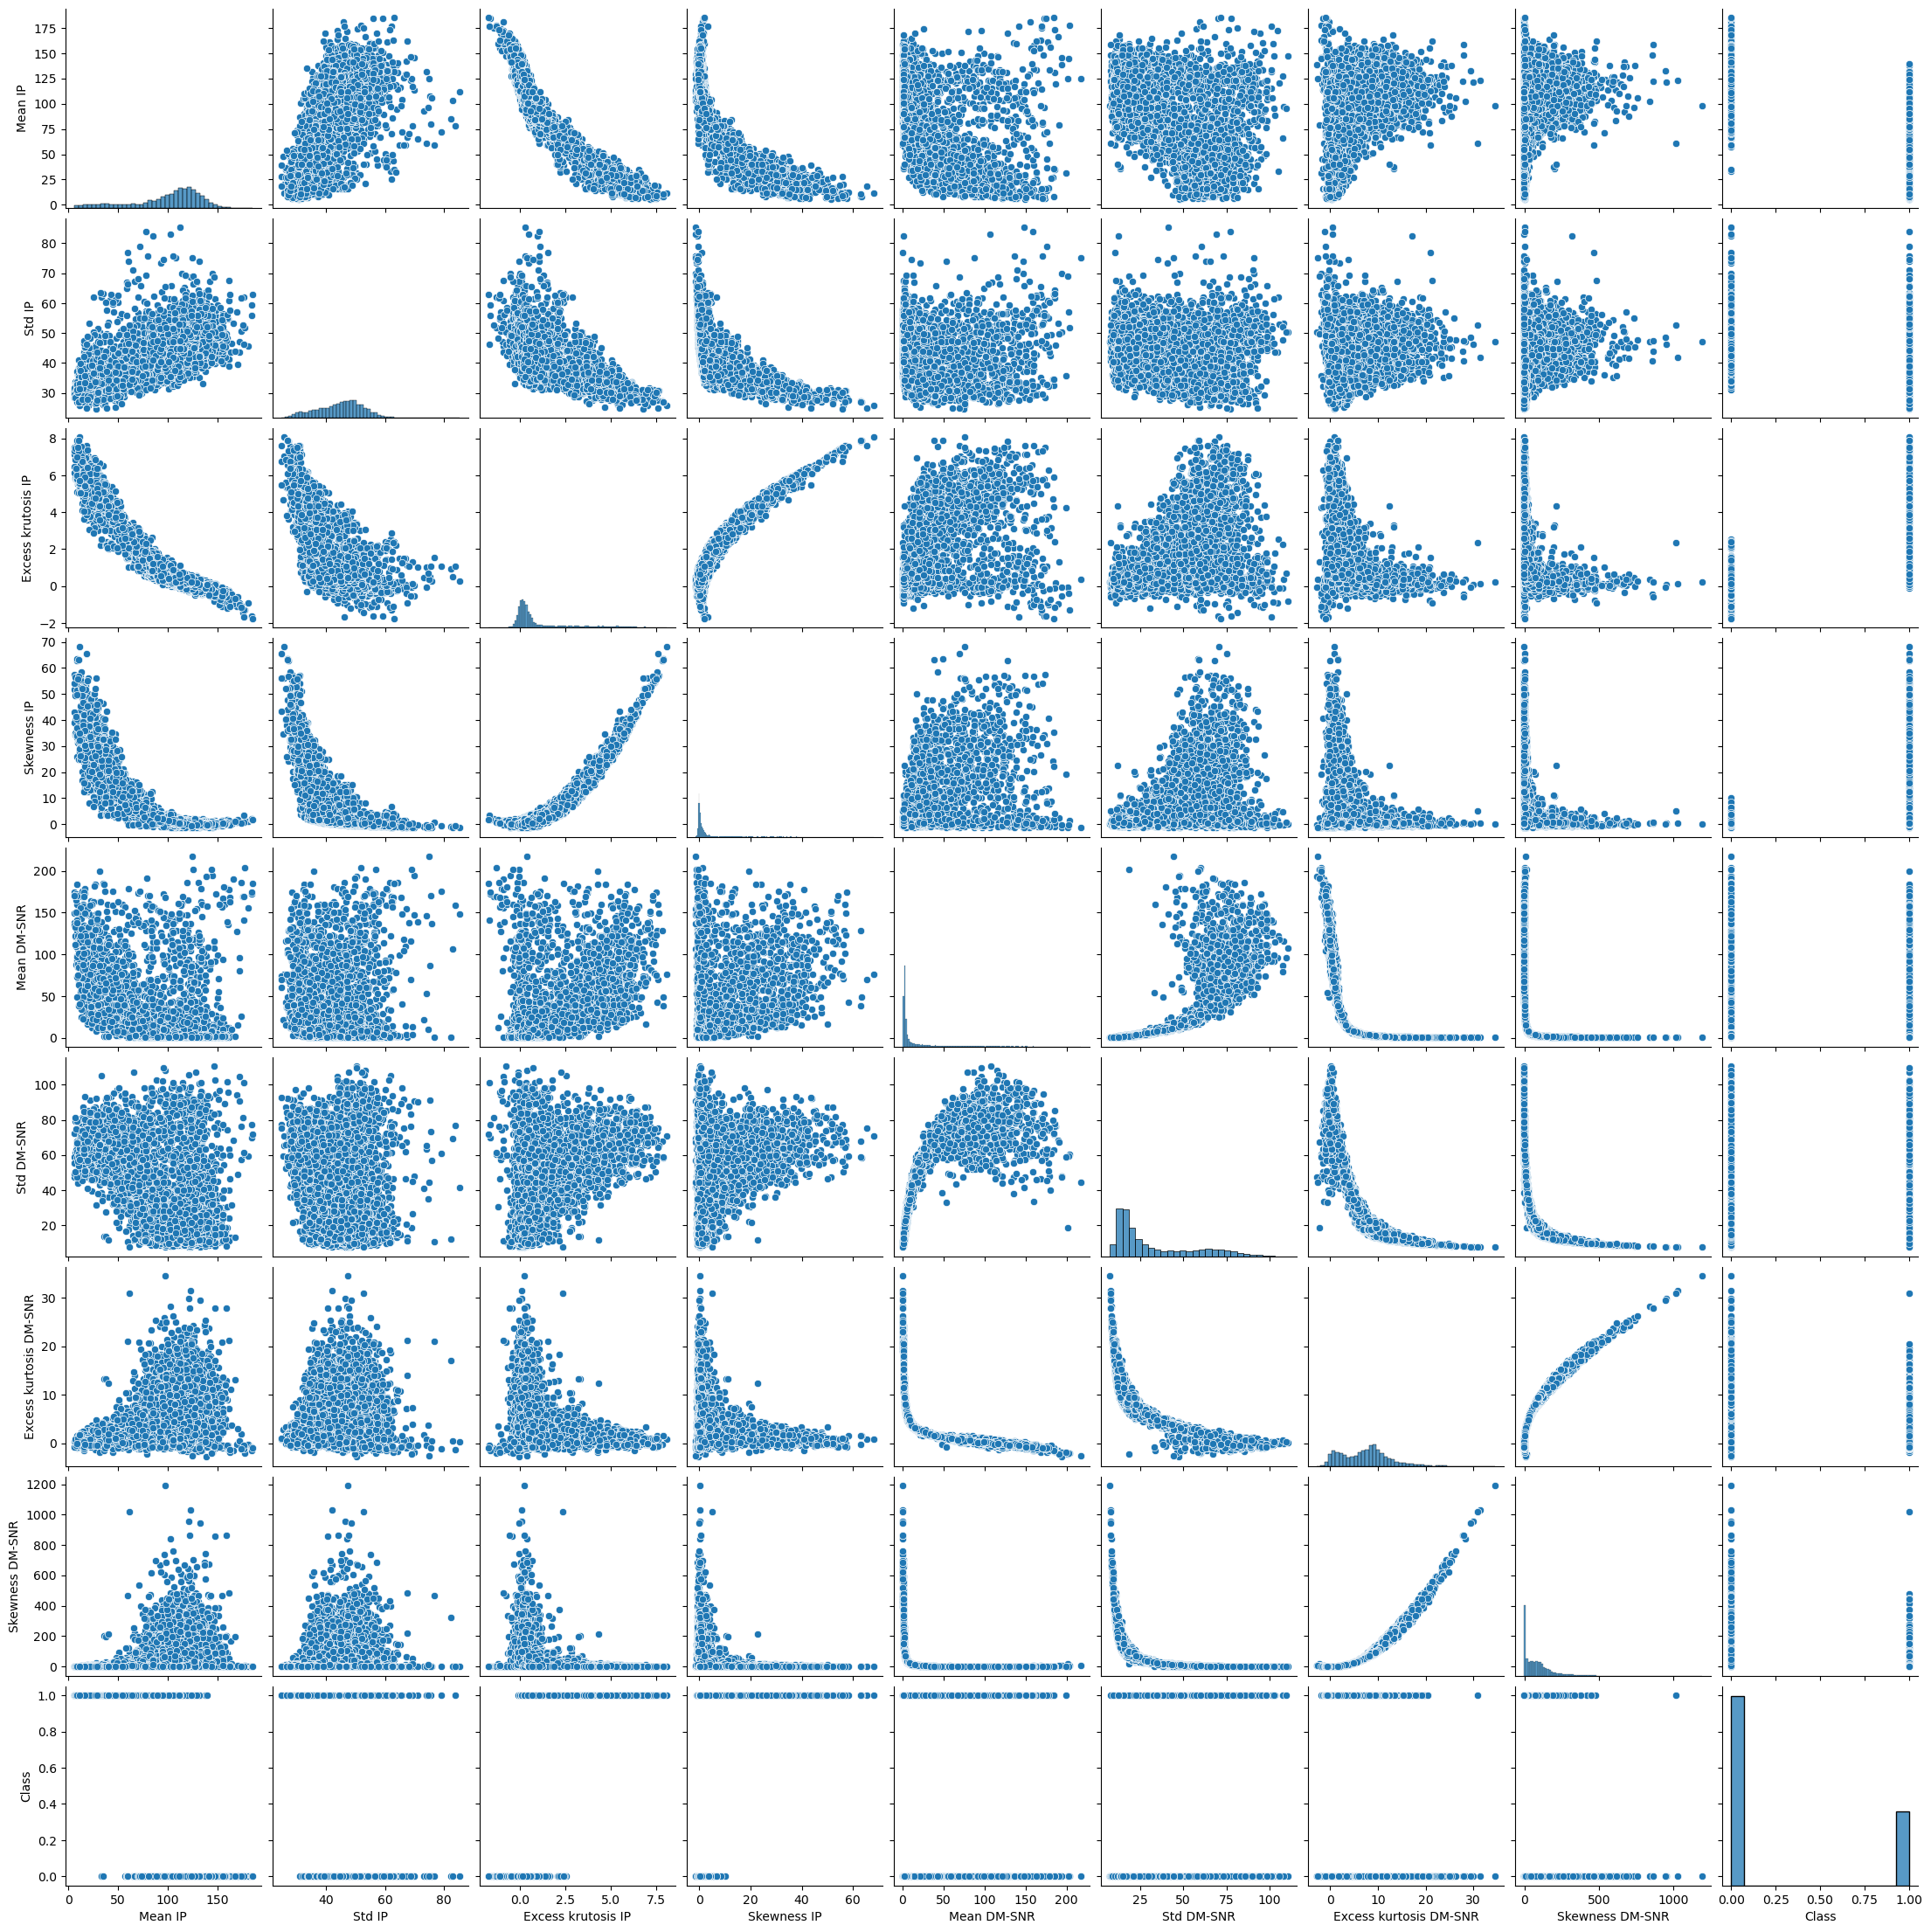

In [63]:
sns.pairplot(data)

In [64]:
X = X[:, :5]

## Podela na trening, val i test set i skaliranje

Podela na 3 skupa će biti 70%/15%/15%. Za skaliranje je korišćen standard scaler: $$x^{(i)} = \frac{x^{(i)}-\mu}{\sigma_x}$$

In [130]:
X_tr, X_re, Y_tr, Y_re = train_test_split(X, Y, train_size=0.7, random_state=42, stratify=Y, shuffle=True)
                                                          
X_val, X_te, Y_val, Y_te = train_test_split(X_re, Y_re, test_size=0.5, random_state=42, stratify=Y_re, shuffle=True)

In [131]:
scaler = StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr)
X_val = scaler.transform(X_val)
X_te = scaler.transform(X_te)

## Arhitektura modela

Mreža se sastoji iz 4 sloja sa po redom: 16, 64, 32 i 16 neurona. Ulaz u mrežu predstavljaju 5 atributa o čemu je već bilo reči. Izazni sloj je 1 neuron koji koristi sigmoidnu aktivacionu funkciju. Ovakva aktivaciona funkcija je izabrana jer se radi o problemu binarne klasifikacije, tako da se izlaz poslednjeg sloja može tumačiti kao verovatnoća pripadanja klasi 0, pošto je sigmoid ograničen na vrednosti od 0 do 1. Kako se radi o problemu binarne klasifikacije nije potreban softmax sloj, vec je dovoljna samo sigmoidna funckija. Kao aktivacione funkcije skrivenih slojeva birane su ReLU funkcije, jer imaju bolje preformanse od sigmoidnih funkcija, bolje rešavaju problem nestajućih i eksplodirajućih gradijenata. Takođe iymeđu svakog sloja i aktivacione funkcije se nalazi BatchNorm sloj, koji normalizuje odbirke u okviru jodnog batch-a i poboljšava efikisnost treniranja mreže.

ReLU funkcija: $f(x) = max(x,0)$

Sigmoid funkcija: $\sigma(x) = \frac{1}{1+e^{-x}}$

BatchNorm:
$$
\mu_\mathcal{B} \leftarrow \frac{1}{m} \sum_{i=1}^{m} x_i \quad \text{// mini-batch srednja vrednost}
$$

$$
\sigma^2_\mathcal{B} \leftarrow \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu_\mathcal{B})^2 \quad \text{// mini-batch varijansa}
$$

$$
\hat{x}_i \leftarrow \frac{x_i - \mu_\mathcal{B}}{\sqrt{\sigma^2_\mathcal{B} + \epsilon}} \quad \text{// normaliyacija}
$$

$$
y_i \leftarrow \gamma \hat{x}_i + \beta = \mathrm{BN}_{\gamma, \beta}(x_i) \quad \text{// skaliranje i pomeranje}
$$


Za loss funckiju je izabrana binary_crossentropy:
$$
\text{BCE} = -\frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log(p_i) + (1 - y_i) \log(1 - p_i) \right]
$$
Ovo koristimo jer vršimo klasifikaciju u dve klase, pa ima smisla gledati gubitak koji u stvari uzima i dobijene verovatnoće za pripadnost klasama koje nam daje neuralna mreža.

Kao optimizator za minimizaciju loss funkcije je izabran AdamW, koji je nadogradnja Adam optimizatora koja bolje barata sa loss funkcijom kada je uključena regularizacija i time obezbeđuje bolju regularizaciju. AdamW kombinuje u sebi adagrad algoritam, momentum i RMSprop, tako da garantuje bržu i stabilniju konvergenciju u poređenju sa drugim algoritmima.

In [142]:
def make_model(learning_rate=0.001, weight_decay=0.01):
    model = Sequential()
    
    model.add(Dense(16, input_dim=5))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(1, activation='sigmoid'))
    
    optimizer = AdamW(learning_rate=learning_rate, weight_decay=weight_decay)
    
    model.compile(optimizer=optimizer, 
                  loss='binary_crossentropy', 
                  metrics=['accuracy']) 
    
    return model

In [143]:
def performanse_modela(model, ulaz_test, izlaz_test):
    izlaz_pred = model.predict(ulaz_test, verbose=0)
    izlaz_pred = np.round(izlaz_pred)

    cm = confusion_matrix(izlaz_test, izlaz_pred)
    ConfusionMatrixDisplay(confusion_matrix = cm).plot()
    plt.show()

    TN = cm[0, 0]
    print(f'True negative: {TN}')
    TP = cm[1, 1]
    print(f'True positive: {TP}')
    FN = cm[1, 0]
    print(f'False negative: {FN}')
    FP = cm[0, 1]
    print(f'False positive: {FP}')

    ACC = (TP+TN) / (TP+FP+TN+FN)
    print(f'Tačnost: {ACC:.4f}')
    P = TP / (TP+FP)
    print(f'Preciznost: {P:.4f}')
    R = TP / (TP+FN)
    print(f'Osetljivost: {R:.4f}')
    F1 = 2*P*R / (P+R)
    print(f'F1: {F1:.4f}')
    ROC = roc_auc_score(izlaz_test, izlaz_pred)
    print(f'ROC: {ROC:.4f}')

In [144]:
weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y_tr), y = Y_tr)
weights_d = {i: w for i, w in enumerate(weights)}

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-5,
    verbose=0
)

early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True,
    verbose=0
)

Pomoću gird search-a ćemo pronaći optimume za sledeće parametre:
- batch_size: određuje broj odbiraka koji se istovremeno prosleđuju modelu tokom jedne propagacije. Utiče na brzinu treniranja i na stabilnost optimizacionog algoritma, s tim u vidu treba odrediti vrednost koja nije ni prevelika, kako vreme potrebno za treniranje ne bi bilo preveliko, ali ni premala, kako bi se obezbedila stabilnost konvergencije.
- epochs: broj epoha tokom kojih ćemo trenirati model
- leraning rate: određuje veličinu koraka kojim se parametri modela menjaju tokom treniranja. Suviše velika vrednost može dovesti do oscilacija ili divergencije, a suviše mala usporava konvergenciju i može zaglaviti model u lokalnom minimumu.
- weight_decay: reguliše jačinu regularizacije obučavanja modela, odnosno dodaje penal za velike težine i sprečava preobučavanje

In [147]:
model = KerasClassifier(
    model=make_model,
    optimizer=AdamW,
    optimizer__learning_rate=0.001,
    optimizer__weight_decay=0.01,
    loss="binary_crossentropy",
    metrics=["accuracy"],
    batch_size=32,
    epochs=50,
    callbacks=[lr_scheduler, early_stop],
    verbose=0
)

params = {
    'batch_size': [32, 64, 128],
    'epochs': [50, 75, 100],
    'model__learning_rate': [5e-2, 1e-2, 5e-3],
    'model__weight_decay': [0.01, 0.005, 0.001]
}

gs = GridSearchCV(estimator=model, param_grid=params, cv=3, verbose=0)

gs.fit(
    X_tr, Y_tr, 
    class_weight=weights_d,
    validation_data=(X_val, Y_val),
    callbacks=[lr_scheduler, early_stop], 
    verbose=0
)

best_params = gs.best_params_

In [148]:
batch_size = best_params['batch_size']
epochs = best_params['epochs']
lr = best_params['model__learning_rate']
weight_decay = best_params['model__weight_decay']
print(f'Najbolja vrednost za batch size {batch_size}')
print(f'Najbolja vrednost za epochs {epochs}')
print(f'Najbolja vrednost za learning rate {lr}')
print(f'Najbolja vrednost za weight decay {weight_decay}')

Najbolja vrednost za batch size 32
Najbolja vrednost za epochs 100
Najbolja vrednost za learning rate 0.05
Najbolja vrednost za weight decay 0.001


In [159]:
model = make_model(lr, weight_decay)
history = model.fit(X_tr, Y_tr,
                   epochs=epochs,
                   batch_size=batch_size,
                   class_weight={0:weights[0],
                                 1:weights[1]},
                    validation_data=(X_val, Y_val), 
                    callbacks=[lr_scheduler, early_stop],
                   verbose=0)

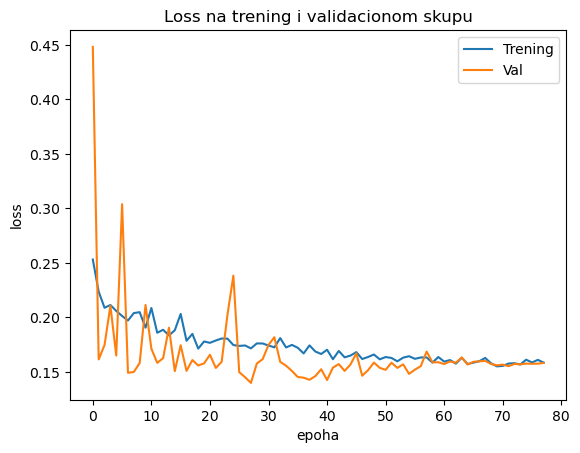

In [160]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss na trening i validacionom skupu')
plt.ylabel('loss')
plt.xlabel('epoha')
plt.legend(['Trening', 'Val'])
plt.show()

Uočavamo da trening kriva konstantno opada, dok val kriva kreće u jednosm trenutku da raste - što predstavlja overfitting. Od ovoga smo se zaštitili pomoću early stop mehanizma.

## Performanse na trening skupu

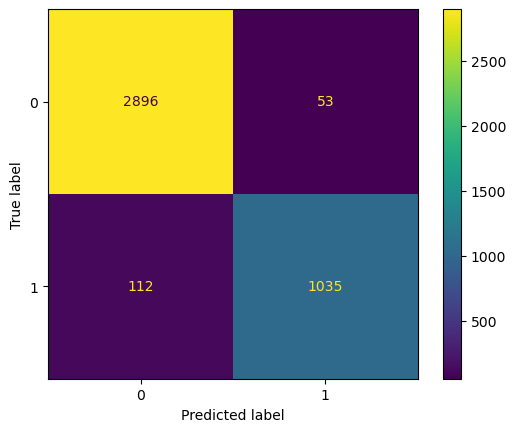

True negative: 2896
True positive: 1035
False negative: 112
False positive: 53
Tačnost: 0.9597
Preciznost: 0.9513
Osetljivost: 0.9024
F1: 0.9262
ROC: 0.9422


In [161]:
performanse_modela(model, X_tr, Y_tr)

## Performanse na validacionom skupu

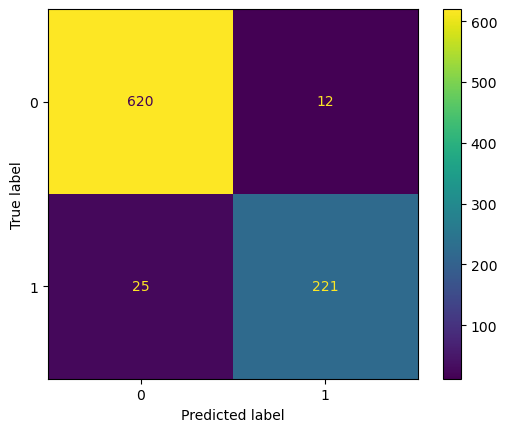

True negative: 620
True positive: 221
False negative: 25
False positive: 12
Tačnost: 0.9579
Preciznost: 0.9485
Osetljivost: 0.8984
F1: 0.9228
ROC: 0.9397


In [162]:
performanse_modela(model, X_val, Y_val)

## Performanse modela na test skupu

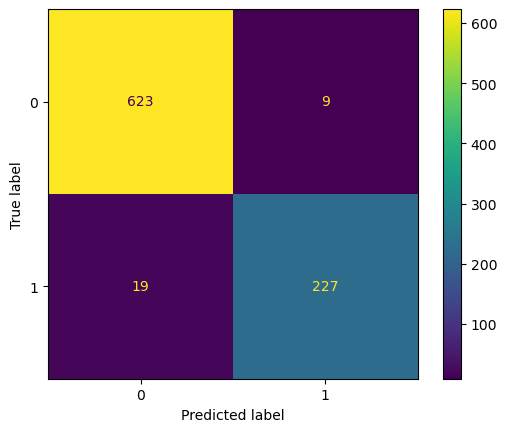

True negative: 623
True positive: 227
False negative: 19
False positive: 9
Tačnost: 0.9681
Preciznost: 0.9619
Osetljivost: 0.9228
F1: 0.9419
ROC: 0.9543


In [163]:
performanse_modela(model, X_te, Y_te)

Model pokazuje odlične performanse i generalizaciju. Ne postoje velike razlike između trening i validacionog, što sugeriše da nije došlo do preobučavanja i da je model stabilan. Ukoliko bismo želeli dodatno da podešavamo Preciznost i Osetljivnost to možemo raditi pomoću podešavanja težina klasa.